In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import warnings 
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, accuracy_score, auc
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Modèle Logit
## Import des données

In [2]:
df = pd.read_csv('../data/df_logit_xgb.csv',sep = ',')

In [3]:
df.head()

,cd_op,MT_REV_PFI,fl_prt_Conso,AMI,MT_EAD_RESID,MT_CHA_HORS_OPE_PFI,fam_PCD,date_entree_defaut,MT_CHA_PIP,MT_CHA_CSM_REV,...,Motif,Situation_fam,Nature,Solution_echec,Nature_op,MTF,ETAT_CIVIL,CSP,CP,ANC_PRO_MAX_PFI_2
0,I860708600,53781.0,0,0.0,-3945.79,0.0,0,2017-01-16,3684.0,660.0,...,2,1,1,1,1,1,2,1,1,0.036025
1,I950404213,42070.0,0,1.0,0.03,0.0,0,2017-03-15,3684.0,660.0,...,2,1,2,1,2,2,1,2,1,0.194694
2,I950706618,46380.0,0,0.0,1078.86,0.0,1,2016-01-28,3684.0,660.0,...,1,1,2,1,2,2,1,1,3,-0.061161
3,I950901248,18822.0,0,0.0,525.06,0.0,0,2017-01-27,3684.0,660.0,...,1,2,2,1,2,2,2,2,1,0.194694
4,I960300578,12804.0,1,0.0,5835.03,2484.0,0,2016-06-28,0.0,2484.0,...,2,1,2,1,2,2,1,2,1,-0.228634


In [4]:
df['arrete'] = pd.to_datetime(df['arrete'])

## Récupération des variables sélectionnées

In [5]:
df_obj = df.select_dtypes(include ='object')

In [6]:
df = df[['Motif', 'niv_gravite_mtf_dfs', 'MTF',
       'ANC_PRO_MAX_PFI_2', 'nb_empr_ope', 'CD_DNE_CHR_LGD_SAIN', 'CP',
         'DET', 'arrete', 'cd_op']]

## Split des données : Entraînement / Validation

In [7]:
# On prend soin d'écarter les données pendant la période Covid

df_validation = df[df['arrete']>"2020-06-30"]
data = df[df['arrete']<"2019-12-31"]

In [8]:
X_train = data.select_dtypes(exclude = 'datetime').copy()
X_test = df_validation.select_dtypes(exclude = 'datetime').copy()

In [9]:
y_train = X_train['DET']
X_train.drop(columns = 'DET', inplace = True)

In [10]:
y_test = X_test['DET']
X_test.drop(columns = 'DET', inplace = True)

In [11]:
X_train.drop(columns = ['cd_op'], inplace = True)
X_test.drop(columns = ['cd_op'], inplace = True)

## Modélisation

In [12]:
model = LogisticRegression(penalty='l1', solver='liblinear')
model = model.fit(X_train, y_train)

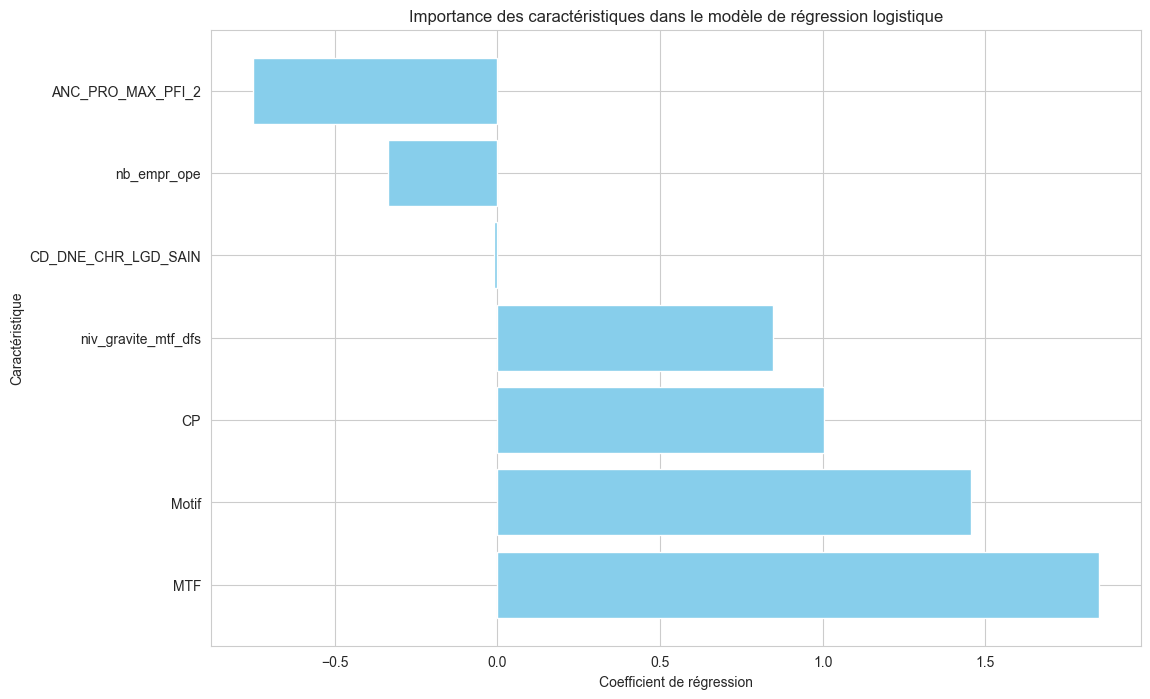

In [13]:
coefficients = model.coef_[0]

feature_names = X_train.columns

feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

feature_importance_df['Abs_Coefficient'] = feature_importance_df['Coefficient']
feature_importance_df = feature_importance_df.sort_values(by='Abs_Coefficient', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Abs_Coefficient'], color='skyblue')
plt.xlabel('Coefficient de régression')
plt.ylabel('Caractéristique')
plt.title('Importance des caractéristiques dans le modèle de régression logistique')
plt.show()

In [14]:
feature_importance_df

,Feature,Coefficient,Abs_Coefficient
2,MTF,1.848511,1.848511
0,Motif,1.455619,1.455619
6,CP,1.003094,1.003094
1,niv_gravite_mtf_dfs,0.847409,0.847409
5,CD_DNE_CHR_LGD_SAIN,-0.010509,-0.010509
4,nb_empr_ope,-0.337871,-0.337871
3,ANC_PRO_MAX_PFI_2,-0.750959,-0.750959


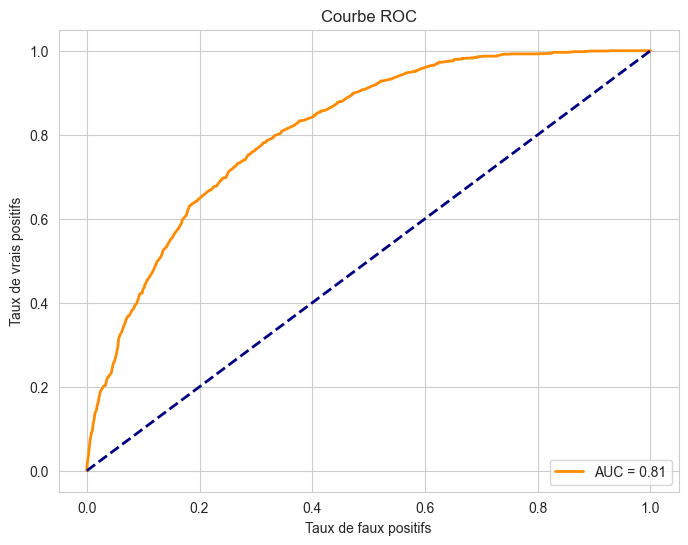

In [15]:
y_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.show()

In [16]:
y_true = y_test
y_pred = model.predict(X_test)
conf_matrix = confusion_matrix(y_true, y_pred)

# Calcul des métriques à partir de la matrice de confusion
true_positive = conf_matrix[1][1]
false_positive = conf_matrix[0][1]
true_negative = conf_matrix[0][0]
false_negative = conf_matrix[1][0]

# Calcul des métriques
accuracy = accuracy_score(y_true, y_pred)
specificity = true_negative / (true_negative + false_positive)
sensitivity = true_positive / (true_positive + false_negative)

print("Précision (Accuracy): {:.2f}".format(accuracy))
print("Spécificité (Specificity): {:.2f}".format(specificity))
print("Sensibilité (Sensitivity): {:.2f}".format(sensitivity))

Précision (Accuracy): 0.77
Spécificité (Specificity): 0.80
Sensibilité (Sensitivity): 0.65


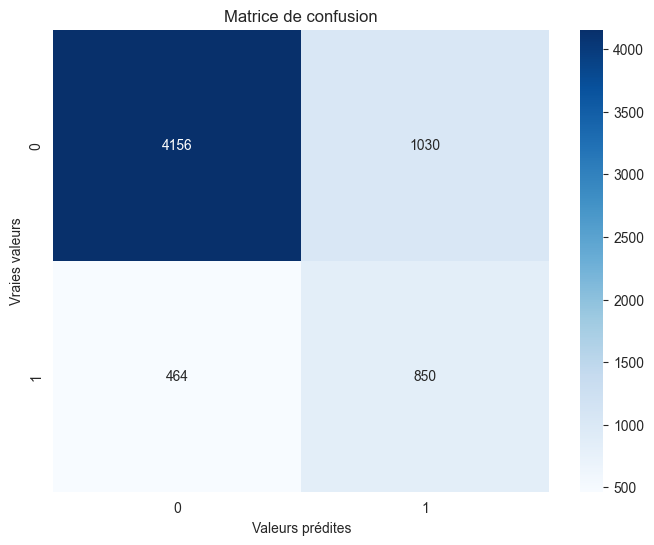

In [17]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Valeurs prédites')
plt.ylabel('Vraies valeurs')
plt.title('Matrice de confusion')
plt.show()